In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

C:\Python34\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
gameTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedGameData.csv')
dvoaTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedDvoaData.csv', encoding='windows-1252')
pffTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedPffData.csv')

In [3]:
# First, turn date cols into dt objects
gameTable['date'] = pd.to_datetime(gameTable['date'])
pffTable['date'] = pd.to_datetime(pffTable['date'])

In [4]:
# Create a table of running averages for pff grades and game scores. Use previous 5-game averages for a team's variables
rollAvgPff = pffTable.set_index('date')

rollAvgPff['avgPf'] = rollAvgPff.groupby('team')['pf'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPa'] = rollAvgPff.groupby('team')['pa'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgOvr'] = rollAvgPff.groupby('team')['overall'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgOff'] = rollAvgPff.groupby('team')['off'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPass'] = rollAvgPff.groupby('team')['pass'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPblk'] = rollAvgPff.groupby('team')['pblk'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRecv'] = rollAvgPff.groupby('team')['recv'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRun'] = rollAvgPff.groupby('team')['run'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRblk'] = rollAvgPff.groupby('team')['rblk'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgDef'] = rollAvgPff.groupby('team')['def'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRdef'] = rollAvgPff.groupby('team')['rdef'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgTack'] = rollAvgPff.groupby('team')['tack'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPrsh'] = rollAvgPff.groupby('team')['prsh'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgCov'] = rollAvgPff.groupby('team')['cov'].apply(lambda x: x.shift(1).rolling(window=7).mean())

rollAvgPff = rollAvgPff.fillna(method='bfill')
rollAvgPff = rollAvgPff.reset_index()

In [5]:
# Need to make new rollingAvgPff tables that have all dates covered... Dates in pff table are off by one or two days
# Strategy is to create new df's that have all dates, then join the normal pff table to each of them by date,
# then merge all the tables together. All dates will be in the final table
pffB1 = rollAvgPff.copy()
pffB1['date'] = pffB1['date'] - datetime.timedelta(days=1)
pffB2 = rollAvgPff.copy()
pffB2['date'] = pffB2['date'] - datetime.timedelta(days=2)
pffF1 = rollAvgPff.copy()
pffF1['date'] = pffF1['date'] + datetime.timedelta(days=1)
pffF2 = rollAvgPff.copy()
pffF2['date'] = pffF2['date'] + datetime.timedelta(days=2)

In [6]:
# Now join pffTable to each new df
t0 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t1 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t2 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t3 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t4 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t5 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t6 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t7 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t8 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t9 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])

In [7]:
awayTable = t0.append([t1,t2,t3,t4],ignore_index=True)
homeTable = t5.append([t6,t7,t8,t9],ignore_index=True)

In [8]:
awayTable['homeAway'] = 'away'
homeTable['homeAway'] = 'home'

In [9]:
awayTable.columns

Index(['gameId', 'date', 'awayTeam', 'awayScore', 'homeTeam', 'homeScore',
       'totalScore', 'overUnder', 'result', 'stadium', 'roof', 'surface',
       'vegasLine', 'referee', 'umpire', 'headLinesman', 'lineJudge',
       'backJudge', 'sideJudge', 'fieldJudge', 'season', 'week', 'team', 'opp',
       'time', 'w', 'pf', 'pa', 'overall', 'off', 'pass', 'pblk', 'recv',
       'run', 'rblk', 'def', 'rdef', 'tack', 'prsh', 'cov', 'spec', 'lateGame',
       'year', 'avgPf', 'avgPa', 'avgOvr', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef', 'avgTack',
       'avgPrsh', 'avgCov', 'homeAway'],
      dtype='object')

In [10]:
awayTable = awayTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]
homeTable = homeTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]

In [11]:
awayTable

,gameId,date,season,week,team,homeAway,stadium,roof,surface,avgPf,...,avgRblk,avgDef,avgRdef,avgPrsh,avgCov,pf,pa,totalScore,overUnder,result
0,201811110kan,2018-11-11,2018,10,Arizona Cardinals,away,Arrowhead Stadium,outdoors,grass,14.857143,...,55.657143,66.342857,64.657143,64.000000,65.514286,14,26,40,49.5,under
1,201610300car,2016-10-30,2016,8,Arizona Cardinals,away,Bank of America Stadium,outdoors,grass,22.714286,...,69.985714,73.785714,70.371429,71.000000,68.414286,20,30,50,45.5,over
2,201612240sea,2016-12-24,2016,16,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,25.857143,...,70.128571,64.900000,63.871429,65.057143,61.528571,34,31,65,43.5,over
3,201812300sea,2018-12-30,2018,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,13.000000,...,60.071429,61.785714,62.857143,62.057143,59.971429,24,27,51,39.5,over
4,201712310sea,2017-12-31,2017,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,18.571429,...,57.585714,73.028571,77.542857,67.028571,66.442857,26,24,50,38.0,over
5,200612030ram,2006-12-03,2006,13,Arizona Cardinals,away,Edward Jones Dome,dome,turf,17.000000,...,59.728571,62.285714,62.142857,59.757143,60.871429,34,20,54,47.0,over
6,201712170was,2017-12-17,2017,15,Arizona Cardinals,away,FedExField,outdoors,grass,16.000000,...,59.857143,67.671429,66.642857,67.157143,64.928571,15,20,35,40.0,under
7,201709100det,2017-09-10,2017,1,Arizona Cardinals,away,Ford Field,dome,turf,30.857143,...,69.157143,68.828571,66.557143,69.042857,65.457143,23,35,58,48.5,over
8,201611270atl,2016-11-27,2016,12,Arizona Cardinals,away,Georgia Dome,dome,turf,21.000000,...,73.200000,73.614286,71.057143,72.371429,66.085714,19,38,57,49.0,over
9,200610010atl,2006-10-01,2006,4,Arizona Cardinals,away,Georgia Dome,dome,turf,17.142857,...,62.185714,67.071429,67.928571,59.771429,66.357143,10,32,42,42.0,push


In [12]:
# Transform week from dvoa table into correct format for analysis (add one)
dvoaTable['week'] = dvoaTable['week'] + 1

In [13]:
# Next, join these tables with DVOA table
awayTable = awayTable.merge(dvoaTable, on=['season','week','team'])
homeTable = homeTable.merge(dvoaTable, on=['season','week','team'])

In [14]:
%store awayTable
%store homeTable
awayTable.columns

Stored 'awayTable' (DataFrame)
Stored 'homeTable' (DataFrame)


Index(['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'pf', 'pa', 'totalScore', 'overUnder', 'result',
       'totalDvoa', 'offDvoa', 'offRank', 'defDvoa', 'defRank', 'stDvoa',
       'stRank'],
      dtype='object')

In [15]:
# We only want the team's offensive and total grade columns and the team's opponent's
# defensive/total grade cols
# We can make two copies of both tables: awayOff, awayDef, homeOff, homeDef. Then join
# awayOff with homeDef, and join homeOff with awayDef and predict team totals for each game
# after transforming variables by combining columns.
awayOff = awayTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
awayDef = awayTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]
homeOff = homeTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
homeDef = homeTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]


In [16]:
homeDef # Now we need to join awayOff w/ homeDef, and homeOff w/awayDef. THEN we can predict implied totals

,gameId,date,season,week,team,stadium,roof,surface,avgPa,avgOvr,avgDef,avgRdef,avgPrsh,avgCov,totalDvoa,defDvoa,totalScore
0,201811110kan,2018-11-11,2018,10,Kansas City Chiefs,Arrowhead Stadium,outdoors,grass,23.000000,77.185714,69.142857,58.228571,73.685714,68.057143,0.438,0.076,40
1,201610300car,2016-10-30,2016,8,Carolina Panthers,Bank of America Stadium,outdoors,grass,28.571429,69.371429,67.071429,66.857143,66.200000,63.071429,-0.093,0.031,50
2,201612240sea,2016-12-24,2016,16,Seattle Seahawks,CenturyLink Field,outdoors,turf,18.000000,71.157143,68.700000,71.157143,64.114286,64.685714,0.100,-0.128,65
3,201812300sea,2018-12-30,2018,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,23.857143,73.585714,66.014286,67.885714,63.100000,61.857143,0.084,0.010,51
4,201712310sea,2017-12-31,2017,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,22.428571,68.742857,68.442857,65.357143,67.928571,68.700000,0.024,-0.052,50
5,201712170was,2017-12-17,2017,15,Washington Redskins,FedExField,outdoors,grass,28.142857,64.500000,62.942857,59.457143,65.928571,61.542857,-0.040,-0.031,35
6,201709100det,2017-09-10,2017,1,Detroit Lions,Ford Field,dome,turf,22.714286,68.928571,63.200000,62.542857,59.271429,61.771429,0.016,0.006,58
7,201611270atl,2016-11-27,2016,12,Atlanta Falcons,Georgia Dome,dome,turf,27.428571,76.857143,66.528571,68.657143,65.671429,62.885714,0.189,0.086,57
8,201612110mia,2016-12-11,2016,14,Miami Dolphins,Hard Rock Stadium,outdoors,grass,22.714286,72.285714,68.600000,66.271429,69.085714,65.685714,-0.004,0.000,49
9,201812020gnb,2018-12-02,2018,13,Green Bay Packers,Lambeau Field,outdoors,grass,26.285714,73.471429,65.985714,65.685714,68.271429,61.300000,0.115,0.016,37


In [17]:
awayMatchup = awayOff.merge(homeDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
homeMatchup = homeOff.merge(awayDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
#awayMatchup.columns

In [18]:
homeMatchup.columns

Index(['gameId', 'date', 'season', 'week', 'team_x', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore', 'team_y', 'avgPa', 'avgOvr_y',
       'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa'],
      dtype='object')

In [19]:
# Now we will create new columns for these two tables by combining matchups
# Ex) add awayMatchup['avgOff'] + awayMatchup['avgDef'] ('avgDef' is the away team's opponent's average defensive grade)
# to turn these two columns into one

awayMatchup['ptsMatchup'] = awayMatchup['avgPf'] + awayMatchup['avgPa']
awayMatchup['offMatchup'] = awayMatchup['avgOff'] - awayMatchup['avgDef']
awayMatchup['ovrMatchup'] = awayMatchup['avgOvr_x'] - awayMatchup['avgOvr_y']
awayMatchup['passMatchup'] = awayMatchup['avgPass'] - awayMatchup['avgCov']
awayMatchup['pblkMatchup'] = awayMatchup['avgPblk'] - awayMatchup['avgPrsh']
awayMatchup['runMatchup'] = awayMatchup['avgRun'] - awayMatchup['avgRdef']
awayMatchup['offDvoaMatchup'] = awayMatchup['offDvoa'] - awayMatchup['defDvoa']
awayMatchup['totalDvoaMatchup'] = awayMatchup['totalDvoa_x'] - awayMatchup['totalDvoa_y']

In [20]:
homeMatchup['ptsMatchup'] = homeMatchup['avgPf'] + homeMatchup['avgPa']
homeMatchup['offMatchup'] = homeMatchup['avgOff'] - homeMatchup['avgDef']
homeMatchup['ovrMatchup'] = homeMatchup['avgOvr_x'] - homeMatchup['avgOvr_y']
homeMatchup['passMatchup'] = homeMatchup['avgPass'] - homeMatchup['avgCov']
homeMatchup['pblkMatchup'] = homeMatchup['avgPblk'] - homeMatchup['avgPrsh']
homeMatchup['runMatchup'] = homeMatchup['avgRun'] - homeMatchup['avgRdef']
homeMatchup['offDvoaMatchup'] = homeMatchup['offDvoa'] - homeMatchup['defDvoa']
homeMatchup['totalDvoaMatchup'] = homeMatchup['totalDvoa_x'] - homeMatchup['totalDvoa_y']

In [21]:
cols = list(awayMatchup.columns)
cols
cols.pop(21)
cols.append('pf')


In [22]:
awayMatchup = awayMatchup[cols]
homeMatchup = homeMatchup[cols]

In [23]:
# Only use weeks > 3 since dvoa is inaccurate before week 3, typically
awayMatchup = awayMatchup[awayMatchup['week'] >= 3]
homeMatchup = homeMatchup[homeMatchup['week'] >= 3]

In [24]:
%store awayMatchup
%store homeMatchup

Stored 'awayMatchup' (DataFrame)
Stored 'homeMatchup' (DataFrame)


In [25]:
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(awayMatchup.iloc[:,:-1],awayMatchup.iloc[:,-1:], test_size=0.2,random_state=745)

In [26]:
# Now we want to predict points for (pf) for the homeMatchup/awayMatchup tables
# Setup table in way to do so:
ID_col = ['gameId']
target_col = ['pf']
cat_cols = ['roof','surface']
num_cols= ['ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 'pblkMatchup',
           'runMatchup', 'totalDvoaMatchup', 'offDvoaMatchup']
other_col= ['date','season','week','stadium','team_x','team_y','homeAway','avgPf',
            'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk','avgRun', 'avgRblk',
            'totalDvoa_x', 'offDvoa','pa', 'totalScore','avgPa', 'avgOvr_y',
            'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa','avgRecv','overUnder']

In [27]:
# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train_away[var] = number.fit_transform(X_train_away[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_away[var] = number.fit_transform(X_test_away[var].astype('str'))

In [28]:
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. Use random forest to predict the class
features=list(set(list(X_train_away.columns))-set(ID_col)-set(target_col)-set(other_col))

In [29]:
%store features

Stored 'features' (list)


In [2135]:
X_train_away = X_train_away[list(features)]
X_test_away= X_test_away[list(features)]

In [2136]:
X_train_away

,offMatchup,runMatchup,ptsMatchup,stDvoa,pblkMatchup,totalDvoaMatchup,roof,surface,offDvoaMatchup,ovrMatchup,passMatchup
1534,-0.085714,-3.457143,42.285714,-0.059,13.371429,-0.107,1,1,-0.074,-4.685714,-5.157143
1584,7.000000,-10.257143,44.714286,-0.095,17.585714,0.364,1,1,-0.123,1.957143,8.657143
1275,6.257143,-26.514286,43.000000,-0.021,18.928571,0.045,1,1,0.294,2.728571,17.542857
104,10.600000,-0.714286,54.714286,-0.077,14.971429,-0.069,0,1,-0.339,2.271429,12.357143
2446,-2.057143,-9.514286,37.857143,0.022,14.842857,-0.193,1,0,-0.331,-8.742857,-4.328571
977,2.842857,-9.642857,43.857143,0.027,7.628571,0.097,1,0,0.169,7.085714,-1.642857
786,-10.300000,-7.528571,45.285714,0.036,-7.928571,-0.453,1,0,-0.325,-14.971429,-14.285714
899,5.114286,-5.342857,36.571429,-0.049,5.800000,-0.306,1,0,0.152,-0.471429,5.157143
2215,3.985714,-9.442857,47.285714,0.004,13.814286,-0.146,1,0,0.200,-3.742857,4.142857
1325,-3.371429,-18.400000,36.285714,-0.008,0.385714,-0.373,1,0,0.193,-0.214286,-0.085714


In [2137]:
# rf = RandomForestRegressor(n_estimators=1000, randoyym_state=0)
# rf.fit(X_train_away, y_train_away)
# y_pred_away = rf.predict(X_test_away)
# print(mean_squared_error(y_test_away, y_pred_away))

# Linear Regression
regressor = LinearRegression()
regressor.fit(X_train_away, y_train_away)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [2138]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_away, y_train_away, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.11096439  0.08400183  0.07271221  0.08688483  0.14457153  0.11067815
  0.04755192  0.11150725  0.03677458  0.13056765]


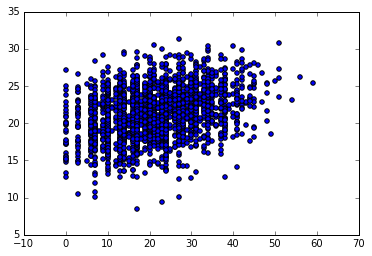

In [2139]:
predictions = cross_val_predict(regressor, X_train_away, y_train_away, cv=10)
plt.scatter(y_train_away, predictions)
plt.show()

In [2140]:
accuracy = metrics.r2_score(y_train_away, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.0986680734456


In [2141]:
#Add column of ones to account for b_0
X_train_away = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_away, axis = 1)
X_train_away[1]

array([  1.        ,   7.        , -10.25714286,  44.71428571,
        -0.095     ,  17.58571429,   0.364     ,   1.        ,
         1.        ,  -0.123     ,   1.95714286,   8.65714286])

In [2142]:
X_opt = X_train_away[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     24.08
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           2.23e-47
Time:                        19:44:54   Log-Likelihood:                -8013.8
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2176   BIC:                         1.612e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7024      2.083      6.577      0.000       9.617      17.788
x1            -0.0190      0.076     -0.251      0.802      -0.167       0.129
x2             0.0635      0.040      1.589      0.112      -0.015       0.142
x3             0.1910      0.045      4.209      0.000       0.102       0.280
x4            -1.7268      4.180     -0.413      0.680      -9.924       6.470
x5            -0.0194      0.031     -0.631      0.528      -0.080       0.041
x6             4.9520      0.951      5.210      0.000       3.088       6.816
x7            -0.8078      0.526     -1.536      0.125      -1.839       0.223
x8            -0.6221      0.467     -1.332      0.183      -1.538       0.294
x9             3.0899      1.005      3.075      0.002       1.119       5.060
x10           -0.0454      0.056     -0.813      0.416      -0.155       0.064
x11            0.1084      0.047      2.301      0.021       0.016       0.201
==============================================================================
Omnibus:                       20.058   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.341
Skew:                           0.227   Prob(JB):                     3.83e-05
Kurtosis:                       2.867   Cond. No.                         970.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2143]:
X_opt = X_train_away[:, [0,1,2,3,4,5,6,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     26.24
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           1.32e-47
Time:                        19:44:54   Log-Likelihood:                -8015.0
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2177   BIC:                         1.611e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9242      2.022      6.393      0.000       8.960      16.889
x1            -0.0137      0.075     -0.182      0.855      -0.162       0.134
x2             0.0684      0.040      1.715      0.086      -0.010       0.147
x3             0.1924      0.045      4.240      0.000       0.103       0.281
x4            -1.7901      4.181     -0.428      0.669      -9.989       6.409
x5            -0.0227      0.031     -0.737      0.461      -0.083       0.038
x6             5.0647      0.948      5.343      0.000       3.206       6.924
x7            -0.2824      0.411     -0.686      0.493      -1.089       0.524
x8             2.9901      1.003      2.981      0.003       1.023       4.957
x9            -0.0515      0.056     -0.924      0.356      -0.161       0.058
x10            0.1072      0.047      2.275      0.023       0.015       0.200
==============================================================================
Omnibus:                       19.767   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.980
Skew:                           0.223   Prob(JB):                     4.59e-05
Kurtosis:                       2.857   Cond. No.                         969.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2144]:
X_opt = X_train_away[:, [0,1,2,3,5,6,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     29.14
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           2.59e-48
Time:                        19:44:55   Log-Likelihood:                -8015.1
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2178   BIC:                         1.611e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9741      2.018      6.430      0.000       9.017      16.931
x1            -0.0123      0.075     -0.163      0.870      -0.160       0.135
x2             0.0683      0.040      1.713      0.087      -0.010       0.146
x3             0.1912      0.045      4.222      0.000       0.102       0.280
x4            -0.0230      0.031     -0.749      0.454      -0.083       0.037
x5             4.9968      0.934      5.347      0.000       3.164       6.829
x6            -0.2837      0.411     -0.690      0.490      -1.090       0.523
x7             2.9868      1.003      2.978      0.003       1.020       4.953
x8            -0.0497      0.056     -0.894      0.371      -0.159       0.059
x9             0.1075      0.047      2.282      0.023       0.015       0.200
==============================================================================
Omnibus:                       19.778   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.979
Skew:                           0.223   Prob(JB):                     4.59e-05
Kurtosis:                       2.855   Cond. No.                         472.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2145]:
X_opt = X_train_away[:, [0,2,3,5,6,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     32.80
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           4.42e-49
Time:                        19:44:55   Log-Likelihood:                -8015.1
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2179   BIC:                         1.610e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9826      2.017      6.438      0.000       9.028      16.937
x1             0.0638      0.029      2.228      0.026       0.008       0.120
x2             0.1901      0.045      4.242      0.000       0.102       0.278
x3            -0.0255      0.027     -0.946      0.344      -0.078       0.027
x4             5.0123      0.929      5.393      0.000       3.190       6.835
x5            -0.2851      0.411     -0.694      0.488      -1.091       0.521
x6             2.9884      1.003      2.981      0.003       1.022       4.954
x7            -0.0521      0.054     -0.973      0.330      -0.157       0.053
x8             0.1020      0.033      3.127      0.002       0.038       0.166
==============================================================================
Omnibus:                       19.754   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.957
Skew:                           0.223   Prob(JB):                     4.64e-05
Kurtosis:                       2.856   Cond. No.                         469.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2146]:
X_opt = X_train_away[:, [0,2,3,6,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     37.35
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           1.08e-49
Time:                        19:44:56   Log-Likelihood:                -8015.5
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2180   BIC:                         1.609e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9682      2.017      6.431      0.000       9.014      16.923
x1             0.0671      0.028      2.364      0.018       0.011       0.123
x2             0.1866      0.045      4.178      0.000       0.099       0.274
x3             5.0397      0.929      5.426      0.000       3.218       6.861
x4            -0.2984      0.411     -0.726      0.468      -1.104       0.507
x5             2.9851      1.003      2.978      0.003       1.019       4.951
x6            -0.0639      0.052     -1.229      0.219      -0.166       0.038
x7             0.1064      0.032      3.297      0.001       0.043       0.170
==============================================================================
Omnibus:                       20.011   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.228
Skew:                           0.224   Prob(JB):                     4.05e-05
Kurtosis:                       2.856   Cond. No.                         463.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2147]:
X_opt = X_train_away[:, [0,2,3,6,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     43.50
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           2.02e-50
Time:                        19:44:56   Log-Likelihood:                -8015.8
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2181   BIC:                         1.609e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8588      2.011      6.395      0.000       8.916      16.802
x1             0.0688      0.028      2.432      0.015       0.013       0.124
x2             0.1863      0.045      4.172      0.000       0.099       0.274
x3             5.0154      0.928      5.404      0.000       3.195       6.836
x4             3.0219      1.001      3.018      0.003       1.059       4.985
x5            -0.0612      0.052     -1.179      0.238      -0.163       0.041
x6             0.1056      0.032      3.275      0.001       0.042       0.169
==============================================================================
Omnibus:                       19.752   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.976
Skew:                           0.223   Prob(JB):                     4.59e-05
Kurtosis:                       2.859   Cond. No.                         462.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2148]:
X_opt = X_train_away[:, [0,2,3,6,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     43.50
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           2.02e-50
Time:                        19:44:56   Log-Likelihood:                -8015.8
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2181   BIC:                         1.609e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8588      2.011      6.395      0.000       8.916      16.802
x1             0.0688      0.028      2.432      0.015       0.013       0.124
x2             0.1863      0.045      4.172      0.000       0.099       0.274
x3             5.0154      0.928      5.404      0.000       3.195       6.836
x4             3.0219      1.001      3.018      0.003       1.059       4.985
x5            -0.0612      0.052     -1.179      0.238      -0.163       0.041
x6             0.1056      0.032      3.275      0.001       0.042       0.169
==============================================================================
Omnibus:                       19.752   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.976
Skew:                           0.223   Prob(JB):                     4.59e-05
Kurtosis:                       2.859   Cond. No.                         462.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2149]:
X_opt = X_train_away[:, [0,3,6,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     50.90
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           4.91e-50
Time:                        19:44:57   Log-Likelihood:                -8018.8
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2182   BIC:                         1.608e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7212      1.958      5.987      0.000       7.882      15.560
x1             0.2056      0.044      4.672      0.000       0.119       0.292
x2             4.9047      0.928      5.285      0.000       3.085       6.725
x3             2.7260      0.995      2.740      0.006       0.775       4.677
x4            -0.0360      0.051     -0.707      0.480      -0.136       0.064
x5             0.0983      0.032      3.057      0.002       0.035       0.161
==============================================================================
Omnibus:                       20.020   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.174
Skew:                           0.222   Prob(JB):                     4.16e-05
Kurtosis:                       2.847   Cond. No.                         447.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2150]:
X_opt = X_train_away[:, [0,3,6,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     63.52
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           7.38e-51
Time:                        19:44:57   Log-Likelihood:                -8019.0
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2183   BIC:                         1.608e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9859      1.921      6.238      0.000       8.218      15.754
x1             0.2001      0.043      4.620      0.000       0.115       0.285
x2             4.5794      0.806      5.683      0.000       2.999       6.160
x3             2.7227      0.995      2.737      0.006       0.772       4.673
x4             0.0910      0.030      2.988      0.003       0.031       0.151
==============================================================================
Omnibus:                       20.041   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.192
Skew:                           0.222   Prob(JB):                     4.12e-05
Kurtosis:                       2.846   Cond. No.                         443.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2151]:
# Optimal model using alpha < 0.05 significance level ^
X_test_away.shape

(548, 11)

In [2152]:
# Now use this model to make predictions on the test set
X_test_away = np.append(arr = np.ones((548,1)).astype(int), values = X_test_away, axis = 1)
X_test_away = X_test_away[:, [0,3,6,9,11]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_away)
y_pred_away = regressor.predict(X_test_away)

In [2153]:
print(mean_squared_error(y_test_away, y_pred_away))

85.5405313223


In [2154]:
# Now repeat the process for homeMatchup table:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(homeMatchup.iloc[:,:-1],homeMatchup.iloc[:,-1:], test_size=0.2,random_state=745)

for var in cat_cols:
    number = LabelEncoder()
    X_train_home[var] = number.fit_transform(X_train_home[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_home[var] = number.fit_transform(X_test_home[var].astype('str'))
    
features=list(set(list(X_train_home.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train_home = X_train_home[list(features)]
X_test_home= X_test_home[list(features)]

In [2155]:
X_train_home.head()

,offMatchup,runMatchup,ptsMatchup,stDvoa,pblkMatchup,totalDvoaMatchup,roof,surface,offDvoaMatchup,ovrMatchup,passMatchup
1534,3.428571,-14.700000,52.571429,0.058,-1.457143,0.107,1,1,0.361,4.685714,10.657143
1584,-1.185714,-6.857143,35.000000,0.013,8.857143,-0.364,1,1,0.025,-1.957143,-8.685714
1275,5.785714,-10.071429,47.857143,-0.021,23.042857,-0.045,1,1,-0.373,-2.728571,6.628571
104,2.928571,-9.985714,43.857143,0.099,10.628571,0.069,0,1,0.471,-2.271429,-0.414286
2446,11.185714,-3.842857,51.571429,-0.003,3.700000,0.193,1,0,0.066,8.742857,16.542857


In [2156]:
regressor = LinearRegression()
regressor.fit(X_train_home, y_train_home)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [2157]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_home, y_train_home, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.11994491  0.12121653  0.17002993  0.08328729  0.08733676  0.07116941
  0.0920571   0.06588739  0.16242206  0.09437621]


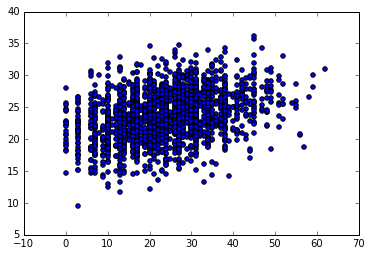

In [2158]:
predictions = cross_val_predict(regressor, X_train_home, y_train_home, cv=10)
plt.scatter(y_train_home, predictions)
plt.show()

In [2159]:
accuracy = metrics.r2_score(y_train_home, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.112555813359


In [2160]:
X_train_home.shape

(2188, 11)

In [2161]:
#Add column of ones to account for b_0
X_train_home = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_home, axis = 1)
X_train_home[1]

array([  1.00000000e+00,  -1.18571429e+00,  -6.85714286e+00,
         3.50000000e+01,   1.30000000e-02,   8.85714286e+00,
        -3.64000000e-01,   1.00000000e+00,   1.00000000e+00,
         2.50000000e-02,  -1.95714286e+00,  -8.68571429e+00])

In [2162]:
X_opt = X_train_home[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     27.66
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           1.04e-54
Time:                        19:45:25   Log-Likelihood:                -8124.9
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2176   BIC:                         1.634e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6555      2.186      6.246      0.000       9.368      17.943
x1             0.0679      0.080      0.847      0.397      -0.089       0.225
x2             0.0079      0.042      0.188      0.851      -0.074       0.090
x3             0.2215      0.047      4.677      0.000       0.129       0.314
x4             6.1469      4.438      1.385      0.166      -2.556      14.850
x5             0.0665      0.033      2.022      0.043       0.002       0.131
x6             5.5375      1.012      5.472      0.000       3.553       7.522
x7            -1.4886      0.550     -2.704      0.007      -2.568      -0.409
x8             0.8395      0.492      1.706      0.088      -0.126       1.805
x9             5.1739      1.025      5.048      0.000       3.164       7.184
x10           -0.1062      0.059     -1.812      0.070      -0.221       0.009
x11            0.0382      0.050      0.770      0.441      -0.059       0.136
==============================================================================
Omnibus:                       24.625   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.185
Skew:                           0.253   Prob(JB):                     3.40e-06
Kurtosis:                       3.142   Cond. No.                         973.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2163]:
X_opt = X_train_home[:, [0,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     30.36
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           2.59e-55
Time:                        19:45:26   Log-Likelihood:                -8125.3
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2177   BIC:                         1.634e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6838      2.186      6.260      0.000       9.397      17.971
x1             0.0328      0.030      1.109      0.268      -0.025       0.091
x2             0.2262      0.047      4.811      0.000       0.134       0.318
x3             6.0083      4.435      1.355      0.176      -2.688      14.705
x4             0.0802      0.029      2.807      0.005       0.024       0.136
x5             5.4638      1.008      5.420      0.000       3.487       7.441
x6            -1.5189      0.549     -2.766      0.006      -2.596      -0.442
x7             0.8184      0.492      1.665      0.096      -0.146       1.782
x8             5.1851      1.025      5.060      0.000       3.175       7.195
x9            -0.0940      0.057     -1.655      0.098      -0.205       0.017
x10            0.0690      0.034      2.036      0.042       0.003       0.135
==============================================================================
Omnibus:                       24.488   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.041
Skew:                           0.252   Prob(JB):                     3.65e-06
Kurtosis:                       3.142   Cond. No.                         967.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2164]:
X_opt = X_train_home[:, [0,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     33.60
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           7.88e-56
Time:                        19:45:27   Log-Likelihood:                -8125.9
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2178   BIC:                         1.633e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2427      2.150      6.161      0.000       9.027      17.458
x1             0.2342      0.046      5.038      0.000       0.143       0.325
x2             6.0015      4.435      1.353      0.176      -2.695      14.698
x3             0.0769      0.028      2.707      0.007       0.021       0.133
x4             5.3824      1.005      5.353      0.000       3.411       7.354
x5            -1.5357      0.549     -2.797      0.005      -2.612      -0.459
x6             0.8027      0.491      1.634      0.102      -0.161       1.766
x7             5.0380      1.016      4.958      0.000       3.045       7.031
x8            -0.0781      0.055     -1.420      0.156      -0.186       0.030
x9             0.0654      0.034      1.939      0.053      -0.001       0.132
==============================================================================
Omnibus:                       25.467   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.091
Skew:                           0.257   Prob(JB):                     2.16e-06
Kurtosis:                       3.149   Cond. No.                         964.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2165]:
X_opt = X_train_home[:, [0,3,4,5,6,7,8,9,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     37.53
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           3.33e-56
Time:                        19:45:28   Log-Likelihood:                -8126.9
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2179   BIC:                         1.632e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8358      2.109      6.560      0.000       9.700      17.972
x1             0.2236      0.046      4.873      0.000       0.134       0.314
x2             6.6280      4.414      1.502      0.133      -2.028      15.284
x3             0.0702      0.028      2.505      0.012       0.015       0.125
x4             4.6663      0.870      5.363      0.000       2.960       6.373
x5            -1.5487      0.549     -2.820      0.005      -2.626      -0.472
x6             0.7508      0.490      1.532      0.126      -0.210       1.712
x7             5.0673      1.016      4.986      0.000       3.074       7.060
x8             0.0492      0.032      1.549      0.121      -0.013       0.111
==============================================================================
Omnibus:                       25.002   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.581
Skew:                           0.255   Prob(JB):                     2.79e-06
Kurtosis:                       3.140   Cond. No.                         958.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2166]:
X_opt = X_train_home[:, [0,3,5,6,7,8,9,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     42.54
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           1.48e-56
Time:                        19:45:28   Log-Likelihood:                -8128.0
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2180   BIC:                         1.632e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.5940      2.104      6.462      0.000       9.469      17.719
x1             0.2275      0.046      4.964      0.000       0.138       0.317
x2             0.0685      0.028      2.445      0.015       0.014       0.123
x3             4.8892      0.858      5.701      0.000       3.207       6.571
x4            -1.4743      0.547     -2.695      0.007      -2.547      -0.402
x5             0.8374      0.487      1.720      0.086      -0.117       1.792
x6             5.1407      1.015      5.063      0.000       3.150       7.132
x7             0.0446      0.032      1.411      0.159      -0.017       0.107
==============================================================================
Omnibus:                       26.024   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.663
Skew:                           0.261   Prob(JB):                     1.62e-06
Kurtosis:                       3.141   Cond. No.                         466.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2167]:
X_opt = X_train_home[:, [0,3,5,6,8,9,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     48.28
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           7.19e-56
Time:                        19:45:29   Log-Likelihood:                -8131.7
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2181   BIC:                         1.632e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0604      2.028      5.947      0.000       8.083      16.038
x1             0.2325      0.046      5.071      0.000       0.143       0.322
x2             0.0613      0.028      2.195      0.028       0.007       0.116
x3             4.6304      0.853      5.426      0.000       2.957       6.304
x4             1.4431      0.432      3.337      0.001       0.595       2.291
x5             5.1618      1.017      5.077      0.000       3.168       7.156
x6             0.0494      0.032      1.562      0.118      -0.013       0.111
==============================================================================
Omnibus:                       25.172   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.763
Skew:                           0.256   Prob(JB):                     2.54e-06
Kurtosis:                       3.141   Cond. No.                         448.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2168]:
X_opt = X_train_home[:, [0,3,6,8,9,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     56.87
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           9.70e-56
Time:                        19:45:29   Log-Likelihood:                -8134.1
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2182   BIC:                         1.631e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0742      2.030      5.948      0.000       8.094      16.055
x1             0.2418      0.046      5.292      0.000       0.152       0.331
x2             4.7792      0.851      5.613      0.000       3.109       6.449
x3             1.4594      0.433      3.372      0.001       0.611       2.308
x4             5.2050      1.017      5.116      0.000       3.210       7.200
x5             0.0459      0.032      1.453      0.146      -0.016       0.108
==============================================================================
Omnibus:                       24.564   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.110
Skew:                           0.254   Prob(JB):                     3.53e-06
Kurtosis:                       3.135   Cond. No.                         442.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2169]:
X_opt = X_train_home[:, [0,3,6,8,9]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     70.53
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           3.07e-56
Time:                        19:45:30   Log-Likelihood:                -8135.1
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2183   BIC:                         1.631e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6761      1.788      5.971      0.000       7.170      14.182
x1             0.2755      0.039      6.992      0.000       0.198       0.353
x2             4.9322      0.845      5.836      0.000       3.275       6.590
x3             1.4748      0.433      3.408      0.001       0.626       2.324
x4             5.3781      1.011      5.321      0.000       3.396       7.360
==============================================================================
Omnibus:                       23.798   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.291
Skew:                           0.250   Prob(JB):                     5.31e-06
Kurtosis:                       3.128   Cond. No.                         397.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2170]:
X_test_home.shape

(548, 11)

In [2171]:
# Now use this model to make predictions on the test set
X_test_home = np.append(arr = np.ones((548,1)).astype(int), values = X_test_home, axis = 1)
X_test_home = X_test_home[:, [0,3,6,8,9]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_home)
y_pred_home = regressor.predict(X_test_home)

In [2172]:
y_test_away

,pf
2335,24
2424,22
1611,27
1396,24
2750,22
2980,31
463,27
1450,17
2707,27
2391,20


In [2173]:
y_test_away = y_test_away.reset_index()
y_test_away = y_test_away[['pf']]
y_test_home = y_test_home.reset_index()
y_test_home = y_test_home[['pf']]

In [2174]:
y_test_away

,pf
0,24
1,22
2,27
3,24
4,22
5,31
6,27
7,17
8,27
9,20


In [2175]:
testDf = pd.DataFrame(X_test_away)
testDf['awayScore'] = y_test_away
testDf['awayPrediction'] = y_pred_away
testDf2 = pd.DataFrame(X_test_home)
testDf2['homeScore'] = y_test_home
testDf2['homePrediction'] = y_pred_home

In [2176]:
testDf = testDf.rename(index=int, columns = {1:'ptsMatchup',2:'totalDvoaMatchup',3:'offDvoaMatchup',4:'passMatchup'})
testDf = testDf.drop(0,axis=1)
testDf

,ptsMatchup,totalDvoaMatchup,offDvoaMatchup,passMatchup,awayScore,awayPrediction
0,43.571429,-0.381,-0.089,6.328571,24,19.295740
1,40.285714,-0.379,-0.207,-4.871429,22,17.306386
2,48.714286,0.215,0.091,1.014286,27,23.060699
3,50.857143,0.086,0.238,16.228571,24,24.684129
4,45.571429,-0.064,-0.192,-7.771429,22,19.583665
5,43.571429,0.423,0.196,13.614286,31,24.416803
6,41.857143,0.265,-0.150,6.242857,27,21.737020
7,44.428571,0.076,-0.165,-2.557143,17,20.544235
8,59.428571,0.330,-0.051,7.814286,27,25.964201
9,36.428571,-0.070,-0.180,-11.371429,20,17.431194


In [2177]:
testDf2.head()

,0,1,2,3,4,homeScore,homePrediction
0,1.0,43.142857,0.381,1.0,-0.264,35,24.495887
1,1.0,37.142857,0.379,1.0,-0.106,29,23.682799
2,1.0,44.000000,-0.215,1.0,-0.009,23,23.163861
3,1.0,38.428571,-0.086,1.0,0.039,31,22.523367
4,1.0,49.000000,0.064,1.0,0.014,35,26.041100


In [2178]:
testDf2 = testDf2.rename(index=int, columns = {1:'ptsMatchup',2:'totalDvoaMatchup',3:'surface',4:'offDvoaMatchup'})
testDf2 = testDf2.drop(0,axis=1)
testDf2

,ptsMatchup,totalDvoaMatchup,surface,offDvoaMatchup,homeScore,homePrediction
0,43.142857,0.381,1.0,-0.264,35,24.495887
1,37.142857,0.379,1.0,-0.106,29,23.682799
2,44.000000,-0.215,1.0,-0.009,23,23.163861
3,38.428571,-0.086,1.0,0.039,31,22.523367
4,49.000000,0.064,1.0,0.014,35,26.041100
5,35.714286,-0.423,0.0,0.147,13,19.219448
6,36.571429,-0.265,1.0,0.034,9,21.101987
7,46.428571,-0.076,0.0,-0.224,10,21.887359
8,39.000000,-0.330,0.0,0.062,6,20.126196
9,43.571429,0.070,0.0,0.038,7,23.229390


In [2202]:
print(np.mean(testDf2[testDf2['surface'] == 1]['homeScore']))
print(np.mean(testDf2[testDf2['surface'] == 0]['homeScore']))

25.1139240506
23.0450160772


In [2179]:
colsAway = list(testDf.columns)
colsAway.pop(-1)
colsAway.pop(-1)
#colsAway
colsHome = list(testDf2.columns)
colsHome.pop(-1)
colsHome.pop(-1)
colsHome.pop(-2)
#colsHome
# cols.pop(7)
# cols.pop(7)

'surface'

In [2180]:
awayPredDf = awayMatchup.merge(testDf, on=colsAway)
homePredDf = homeMatchup.merge(testDf2, on=colsHome)

In [2181]:
awayHomeMerge = awayPredDf.merge(homePredDf, on=['gameId','date','season','week'])
#awayHomeMerge.columns

In [2182]:
awayHomeMerge = awayHomeMerge[['gameId', 'date', 'season', 'week','awayPrediction', 'homePrediction']]
awayHomeMerge.head()

,gameId,date,season,week,awayPrediction,homePrediction
0,201612240sea,2016-12-24,2016,16,20.791324,28.288346
1,201610060sfo,2016-10-06,2016,5,20.506247,23.001851
2,201609250buf,2016-09-25,2016,3,24.364662,23.065844
3,201611200min,2016-11-20,2016,11,18.966099,23.126928
4,201812230car,2018-12-23,2018,16,22.620928,23.386906


In [2183]:
finalDf = gameTable.merge(awayHomeMerge, on=['gameId', 'date'])
finalDf['totalPrediction'] = finalDf['awayPrediction'] + finalDf['homePrediction']
#finalDf.columns

In [2184]:
finalDf = finalDf[['gameId', 'date', 'season', 'week', 'awayTeam', 'awayPrediction', 'awayScore',
                   'homeTeam','homePrediction', 'homeScore', 'overUnder', 'result', 'totalPrediction', 'totalScore']]

In [2185]:
finalDf.head()

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
0,201501030car,2015-01-03,2014,18,Arizona Cardinals,16.403360,16,Carolina Panthers,22.012641,27,37.5,over,38.416001,43
1,201612240sea,2016-12-24,2016,16,Arizona Cardinals,20.791324,34,Seattle Seahawks,28.288346,31,43.5,over,49.079671,65
2,201210040ram,2012-10-04,2012,5,Arizona Cardinals,20.635304,3,Los Angeles Rams,20.748315,17,38.0,under,41.383619,20
3,201610060sfo,2016-10-06,2016,5,Arizona Cardinals,20.506247,33,San Francisco 49ers,23.001851,21,42.5,over,43.508098,54
4,201312010phi,2013-12-01,2013,13,Arizona Cardinals,19.976521,21,Philadelphia Eagles,25.009374,24,48.0,under,44.985895,45


In [2186]:
finalDf[finalDf['season'] == 2018]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
10,201812230car,2018-12-23,2018,16,Atlanta Falcons,22.620928,24,Carolina Panthers,23.386906,10,46.0,under,46.007834,34
42,201812220sdg,2018-12-22,2018,16,Baltimore Ravens,19.130053,22,Los Angeles Chargers,26.957002,10,42.5,under,46.087054,32
55,201812230nwe,2018-12-23,2018,16,Buffalo Bills,16.364405,12,New England Patriots,27.693081,24,45.0,under,44.057486,36
67,201810140was,2018-10-14,2018,6,Carolina Panthers,20.958715,17,Washington Redskins,21.324370,23,44.5,under,42.283085,40
83,201812230sfo,2018-12-23,2018,16,Chicago Bears,23.415068,14,San Francisco 49ers,19.808737,9,44.0,under,43.223805,23
91,201809230crd,2018-09-23,2018,3,Chicago Bears,23.887402,16,Arizona Cardinals,12.658879,14,39.0,under,36.546281,30
120,201811250cin,2018-11-25,2018,12,Cleveland Browns,22.791191,35,Cincinnati Bengals,27.654965,20,46.5,over,50.446156,55
125,201810210tam,2018-10-21,2018,7,Cleveland Browns,21.223485,23,Tampa Bay Buccaneers,26.844715,26,52.5,under,48.068200,49
142,201901120ram,2019-01-12,2018,19,Dallas Cowboys,20.698831,22,Los Angeles Rams,27.425593,30,48.0,over,48.124424,52
154,201810070nyj,2018-10-07,2018,5,Denver Broncos,21.642369,16,New York Jets,21.443336,34,43.0,over,43.085705,50


In [2192]:
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 3]
undersDf['result'].value_counts()

under    44
over     25
push      2
Name: result, dtype: int64

In [2191]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 3]
oversDf['result'].value_counts()

over     73
under    59
push      1
Name: result, dtype: int64

In [2193]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 3]
oversDf[oversDf['season'] == 2017]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
48,201801070jax,2018-01-07,2017,18,Buffalo Bills,17.331956,3,Jacksonville Jaguars,25.635509,10,39.5,under,42.967465,13
62,201710080cin,2017-10-08,2017,5,Buffalo Bills,20.622089,16,Cincinnati Bengals,21.646660,20,39.0,under,42.268749,36
102,201711120oti,2017-11-12,2017,10,Cincinnati Bengals,20.162934,20,Tennessee Titans,23.417825,24,40.5,over,43.580759,44
210,201711270rav,2017-11-27,2017,12,Houston Texans,20.603403,16,Baltimore Ravens,24.551134,23,39.5,under,45.154537,39
216,201710010sea,2017-10-01,2017,4,Indianapolis Colts,18.243783,18,Seattle Seahawks,26.886728,46,41.5,over,45.130510,64
242,201801140pit,2018-01-14,2017,19,Jacksonville Jaguars,21.287032,45,Pittsburgh Steelers,27.056003,42,40.5,over,48.343035,87
267,201710150jax,2017-10-15,2017,6,Los Angeles Rams,19.088280,27,Jacksonville Jaguars,26.739211,17,42.0,over,45.827491,44
302,201801210phi,2018-01-21,2017,20,Minnesota Vikings,21.790607,7,Philadelphia Eagles,21.640767,38,39.0,over,43.431374,45
387,201712100den,2017-12-10,2017,14,New York Jets,24.277806,0,Denver Broncos,19.431420,23,40.5,under,43.709227,23
422,201712170nyg,2017-12-17,2017,15,Philadelphia Eagles,28.739714,34,New York Giants,18.156488,29,40.5,over,46.896202,63


In [2190]:
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 1]
undersDf[undersDf['season'] == 2017]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
127,201712030sdg,2017-12-03,2017,13,Cleveland Browns,14.183400,10,Los Angeles Chargers,26.840465,19,45.0,under,41.023865,29
139,201710220sfo,2017-10-22,2017,7,Dallas Cowboys,23.398770,40,San Francisco 49ers,20.888697,10,48.0,over,44.287467,50
315,201712170pit,2017-12-17,2017,15,New England Patriots,23.558838,27,Pittsburgh Steelers,22.838232,24,52.5,under,46.397071,51
321,201712030buf,2017-12-03,2017,13,New England Patriots,26.473331,23,Buffalo Bills,18.959459,3,48.5,under,45.432791,26
339,201711260ram,2017-11-26,2017,12,New Orleans Saints,23.123217,20,Los Angeles Rams,23.965250,26,54.0,under,47.088467,46
386,201711120tam,2017-11-12,2017,10,New York Jets,21.839791,10,Tampa Bay Buccaneers,20.791249,15,44.5,under,42.631041,25
397,201709240was,2017-09-24,2017,3,Oakland Raiders,24.585573,10,Washington Redskins,20.298425,27,53.5,under,44.883999,37
427,201710010sdg,2017-10-01,2017,4,Philadelphia Eagles,22.735410,26,Los Angeles Chargers,21.053466,24,48.0,over,43.788876,50
435,201711120clt,2017-11-12,2017,10,Pittsburgh Steelers,25.590178,20,Indianapolis Colts,18.908610,17,47.0,under,44.498788,37
484,201711260sfo,2017-11-26,2017,12,Seattle Seahawks,24.921509,24,San Francisco 49ers,18.846561,13,45.0,under,43.768069,37


In [3768]:
#USING 0 POINT OVERS DEFINITION
# rs - record - %
# 1229 - 184/134/8 - 57.9%
# 4375 - 185/176/5 - 51.3%
# 187 - 165/200/4 - 45.2%
# 333 - 172/199/6 - 46.4%
# 399 - 185/169/8 - 52.3%
# 472 - 179/168/9 - 51.6%
# 901 - 188/173/10 - 52.1%
# 2336 - 171/168/10 - 50.4%
# 403 - 195/171/4 - 53.3%
# 407 - 178/158/7 - 53.0%
# 511 - 182/157/5 - 53.7%
# 698 - 171/164/5 - 51.0%
# 222 - 153/155/5 - 49.7%
# 223 - 170/174/7 - 49.4%
# 657 - 176/168/2 - 51.2%

#USING 3 POINT OVERS DEFINITION
# rs - record - %
# 890 - 68/55/6 - 55.3%
# 0 - 62/48/3 - 56.4%
# 1 - 56/46/2 - 54.9%
# 122 - 77/64/2 - 54.6%
# 731 - 58/56/3 - 50.9%
# 556 - 69/46/4 - 60%
# 1229 - 75/43/4 - 63.6%
# 4375 - 78/59/3 - 56.9%
# 187 - 65/73/2 - 47.1%
# 333 - 75/76/3 - 49.7%
# 399 - 65/62/3 - 51.2%
# 472 - 66/50/5 - 56.9%
# 901 - 69/55/5 - 55.6%
# 2336 - 73/47/3 - 60.8%
# 403 - 81/45/2 - 64.3%
# 407 - 54/50/3 - 51.9%
# 511 - 75/57/2 - 56.8%
# 698 - 64/55/2 - 53.8%
# 222 - 44/53/3 - 45.4%
# 223 - 66/56/2 - 54.1%
# 657 - 60/47 - 56.1%


#USING 5 POINT OVERS DEFINITION
# rs - record - %
# 890 - 25/19/3 - 56.8%
# 0 - 30/14/1 - 68.2%
# 1 - 18/17/1 - 51.4%
# 122 - 36/20 - 64.3%
# 731 - 27/16 - 62.8%
# 556 - 27/13/2 - 67.5%%
# 1229 - 27/17/2 - 61.4%
# 4375 - 27/28 - 49.1%
# 187 - 26/20/1 - 56.5%
# 333 - 31/21/1 - 59.6%
# 399 - 21/24/1 - 46.7%
# 472 - 26/13/3 - 66.7%
# 901 - 23/19/1 - 54.8%
# 2336 - 33/19/3 - 63.5%
# 403 - 38/16 - 70.4%
# 407 - 24/23/2 - 51.1%
# 511 - 28/21 - 57.1%
# 698 - 20/16/1 - 55.6%
# 222 - 14/17/2 - 45.2%
# 223 - 26/21/1 - 55.3%
# 657 - 17/16 - 51.5%

In [3773]:
oversDf[oversDf['week'] == 1]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
4,201009120ram,2010-09-12,2010,1,Arizona Cardinals,22.389061,17,Los Angeles Rams,22.161775,13,39.5,under,44.550835,30
102,201209090tam,2012-09-09,2012,1,Carolina Panthers,26.918941,10,Tampa Bay Buccaneers,22.862580,16,45.5,under,49.781521,26
115,200809070clt,2008-09-07,2008,1,Chicago Bears,18.687336,29,Indianapolis Colts,28.687980,13,44.0,under,47.375316,42
143,201409070pit,2014-09-07,2014,1,Cleveland Browns,18.010455,27,Pittsburgh Steelers,28.322505,30,41.5,over,46.332960,57
144,201609110phi,2016-09-11,2016,1,Cleveland Browns,21.439432,10,Philadelphia Eagles,24.415808,29,41.5,under,45.855240,39
199,200709090buf,2007-09-09,2007,1,Denver Broncos,18.004482,15,Buffalo Bills,24.670617,14,37.0,under,42.675099,29
207,200809070atl,2008-09-07,2008,1,Detroit Lions,22.774539,21,Atlanta Falcons,22.931267,34,41.0,over,45.705806,55
331,200709090was,2007-09-09,2007,1,Miami Dolphins,17.871058,13,Washington Redskins,22.359050,16,34.5,under,40.230107,29
356,201609110oti,2016-09-11,2016,1,Minnesota Vikings,23.546006,25,Tennessee Titans,20.166286,16,40.0,over,43.712292,41
474,201409070nyj,2014-09-07,2014,1,Oakland Raiders,20.304851,14,New York Jets,26.212102,19,40.0,under,46.516953,33


In [3750]:
#USING 0 POINT UNDER DEFINITION
# rs - record - %
# 1229 - 157/138/3 - 53.2%
# 4375 - 137/116/5 - 54.2%
# 187 - 150/100/5 - 60%
# 333 - 124/118/5 - 51.2%
# 399 - 132/129/1 - 50.6%
# 472 - 141/125 - 53%
# 901 - 136/114/3 - 54.4%
# 2336 - 141/132/2 - 51.6%
# 403 - 141/111/2 - 55.9%
# 407 - 144/134/3 - 51.8%
# 511 - 134/144/2 - 48.2%
# 698 - 148/135/1 - 52.3%
# 222 - 149/158/4 - 48.5%
# 223 - 130/138/5 - 48.5%
# 657 - 141/135/2 - 51.1%

#USING 3 POINT UNDER DEFINITION
# rs - record - %
# 890 - 34/27/2 - 55.7%
# 0 - 60/35 - 63.2%
# 1 - 30/40/2 - 42.8%
# 122 - 40/37/1 - 52%
# 731 - 30/43/2 - 41.1%
# 556 - 39/32/2 - 54.9%
# 1229 - 45/44 - 50.6%
# 4375 - 43/29/1 - 59.7%
# 187 - 38/32/1 - 54.3%
# 333 - 33/24/2 - 57.9%
# 399 - 35/33 - 51.5%
# 472 - 39/35/1 - 52.7%
# 901 - 37/27/2 - 57.8%
# 2336 - 42/31/1 - 57.5%
# 403 - 42/27/1 - 60.9%
# 407 - 43/49/1 - 46.7%
# 511 - 41/49 - 45.6%
# 698 - 45/38 - 54.2%
# 222 - 45/49/1 - 47.9%
# 223 - 42/26/2 - 61.8%
# 657 - 45/30/1 - 60.0%

#USING 5 POINT UNDER DEFINITION
# rs - record - %
# 890 - 13/7 - 65%
# 0 - 17/9 - 65.4%
# 1 - 7/10/2 - 41.2%
# 122 - 15/10 - 60%
# 731 - 6/11/1 - 35.3%
# 556 - 14/6 - 70%
# 1229 - 15/12 - 55.6%
# 4375 - 11/6 - 64.7%
# 187 - 12/7 - 63.2%
# 333 - 9/5/1 - 64.3%
# 399 - 8/6 - 57.1%
# 472 - 8/6 - 57.1%
# 901 - 9/7 - 56.3%
# 2336 - 14/9 - 60.9%
# 403 - 13/4 - 56.4%
# 407 - 16/12 - 57.1%
# 511 - 13/17 - 43.3%
# 698 - 12/9 - 57.1%
# 222 - 15/21 - 41.7%
# 223 - 14/2/1 - 87.5%
# 657 - 13/9/1 - 59.1%

In [3752]:
undersDf[undersDf['season'] == 2017]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
35,201712240nor,2017-12-24,2017,16,Atlanta Falcons,20.295345,13,New Orleans Saints,27.289588,23,52.0,under,47.584933,36
321,201710010dal,2017-10-01,2017,4,Los Angeles Rams,20.933757,35,Dallas Cowboys,26.291936,30,51.0,over,47.225693,65
367,201712170pit,2017-12-17,2017,15,New England Patriots,23.193767,27,Pittsburgh Steelers,24.014447,24,52.5,under,47.208214,51
405,201712070atl,2017-12-07,2017,14,New Orleans Saints,23.150530,17,Atlanta Falcons,23.823302,20,51.5,under,46.973832,37
459,201712100kan,2017-12-10,2017,14,Oakland Raiders,20.952917,15,Kansas City Chiefs,23.252191,26,48.5,under,44.205108,41
479,201710010den,2017-10-01,2017,4,Oakland Raiders,19.419503,10,Denver Broncos,21.408810,16,44.0,under,40.828313,26


In [3753]:
g50Df = finalDf[finalDf['homePrediction'] > 30]

In [3754]:
g50Df

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
0,200901100car,2009-01-10,2008,19,Arizona Cardinals,21.456114,33,Carolina Panthers,30.109499,13,49.5,under,51.565614,46
13,201209160nwe,2012-09-16,2012,2,Arizona Cardinals,14.661796,20,New England Patriots,33.036047,18,47.0,under,47.697843,38
41,201812090kan,2018-12-09,2018,14,Baltimore Ravens,20.335024,24,Kansas City Chiefs,30.268742,27,48.5,over,50.603766,51
47,201301200nwe,2013-01-20,2012,20,Baltimore Ravens,18.863207,28,New England Patriots,30.841332,13,51.5,under,49.704539,41
69,201201010nwe,2012-01-01,2011,17,Buffalo Bills,17.713905,21,New England Patriots,31.585109,49,50.0,over,49.299014,70
86,200909200atl,2009-09-20,2009,2,Carolina Panthers,12.812757,20,Atlanta Falcons,32.541510,28,43.5,over,45.354266,48
87,201209300atl,2012-09-30,2012,4,Carolina Panthers,17.782448,28,Atlanta Falcons,30.437891,30,48.0,over,48.220339,58
95,201201010nor,2012-01-01,2011,17,Carolina Panthers,21.116914,17,New Orleans Saints,30.822088,45,55.0,over,51.939002,62
139,201312080nwe,2013-12-08,2013,14,Cleveland Browns,17.978222,26,New England Patriots,31.168725,27,47.5,over,49.146947,53
140,200710070nwe,2007-10-07,2007,5,Cleveland Browns,13.381684,17,New England Patriots,33.741859,34,48.0,over,47.123543,51


In [384]:
# Now repeat the process for homeMatchup table:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(homeMatchup.iloc[:,:-1],homeMatchup.iloc[:,-1:], test_size=0.2,randyyom_state=890)

for var in cat_cols:
    number = LabelEncoder()
    X_train_home[var] = number.fit_transform(X_train_home[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_home[var] = number.fit_transform(X_test_home[var].astype('str'))
    
features=list(set(list(X_train_away.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train_home = X_train_home[list(features)]
X_test_home= X_test_home[list(features)]

In [385]:
rf = RandomForestRegressor(n_estimators=1000, randoyym_state=0)
rf.fit(X_train_home, y_train_home)
y_pred_home = rf.predict(X_test_home)

print(mean_squared_error(y_test_home, y_pred_home))

C:\Python34\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


47.9000733077


In [386]:
testDf = pd.DataFrame(X_test_away)
testDf['awayScore'] = y_test_away
testDf['awayPrediction'] = y_pred_away
#testDf.columns

In [387]:
testDf.head()

,ptsMatchup,stDvoa,totalScore,totalDvoaMatchup,pblkMatchup,offMatchup,avgPa,roof,surface,offDvoaMatchup,runMatchup,ovrMatchup,passMatchup,awayScore,awayPrediction
2626,57.714286,-0.011,30,0.663,10.628571,18.357143,33.714286,1,0,0.078,-1.642857,13.257143,23.485714,24,18.015
585,42.142857,0.014,51,0.333,5.100000,-2.471429,21.714286,1,0,0.071,-8.557143,1.271429,3.414286,27,24.324
554,39.000000,-0.070,34,-0.271,6.271429,-1.571429,13.857143,0,1,0.316,-9.885714,-7.957143,-0.671429,10,14.340
2121,46.857143,0.006,42,0.105,7.885714,17.685714,17.428571,1,0,0.350,2.285714,5.942857,19.928571,17,21.043
219,38.428571,-0.022,43,-0.055,-6.742857,-3.214286,19.571429,1,0,-0.072,-6.714286,-2.914286,-10.442857,10,19.444


In [388]:
testDf2 = pd.DataFrame(X_test_home)
testDf2['homeScore'] = y_test_home
testDf2['homePrediction'] = y_pred_home

In [389]:
testDf2.head()

,ptsMatchup,stDvoa,totalScore,totalDvoaMatchup,pblkMatchup,offMatchup,avgPa,roof,surface,offDvoaMatchup,runMatchup,ovrMatchup,passMatchup,homeScore,homePrediction
2626,35.571429,-0.010,30,-0.663,12.842857,1.628571,22.714286,1,0,-0.713,1.185714,-13.257143,-4.200000,6,9.912
585,38.000000,0.002,51,-0.333,5.485714,-4.428571,24.857143,1,0,-0.448,-6.257143,-1.271429,-1.100000,24,23.761
554,55.285714,0.049,34,0.271,1.900000,13.957143,29.571429,0,1,-0.117,0.428571,7.957143,13.528571,24,21.440
2121,44.857143,0.015,42,-0.105,3.057143,10.014286,23.285714,1,0,-0.037,-4.757143,-5.942857,7.628571,25,21.346
219,42.000000,0.066,43,0.055,12.400000,-0.328571,20.142857,1,0,0.194,-6.800000,2.914286,-3.285714,33,24.045


In [390]:
awayMatchup.columns

Index(['gameId', 'date', 'season', 'week', 'team_x', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'totalScore', 'team_y', 'avgPa', 'avgOvr_y',
       'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa',
       'ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 'pblkMatchup',
       'runMatchup', 'offDvoaMatchup', 'totalDvoaMatchup', 'pf'],
      dtype='object')

In [391]:
cols = list(testDf.columns)
cols.pop(-1)
cols.pop(-1)
cols.pop(7)
cols.pop(7)
#cols

'surface'

In [392]:
awayPredDf = awayMatchup.merge(testDf, on=cols)
homePredDf = homeMatchup.merge(testDf2, on=cols)

In [393]:
awayHomeMerge = awayPredDf.merge(homePredDf, on=['gameId','date','season','week'])
awayHomeMerge.columns

Index(['gameId', 'date', 'season', 'week', 'team_x_x', 'homeAway_x',
       'stadium_x', 'roof_x_x', 'surface_x_x', 'avgPf_x', 'avgOvr_x_x',
       'avgOff_x', 'avgPass_x', 'avgPblk_x', 'avgRecv_x', 'avgRun_x',
       'avgRblk_x', 'totalDvoa_x_x', 'offDvoa_x', 'stDvoa_x', 'overUnder_x',
       'pf_x', 'totalScore_x', 'team_y_x', 'avgPa_x', 'avgOvr_y_x', 'avgDef_x',
       'avgRdef_x', 'avgPrsh_x', 'avgCov_x', 'totalDvoa_y_x', 'defDvoa_x',
       'ptsMatchup_x', 'offMatchup_x', 'ovrMatchup_x', 'passMatchup_x',
       'pblkMatchup_x', 'runMatchup_x', 'offDvoaMatchup_x',
       'totalDvoaMatchup_x', 'pf_x', 'roof_y_x', 'surface_y_x', 'awayScore',
       'awayPrediction', 'team_x_y', 'homeAway_y', 'stadium_y', 'roof_x_y',
       'surface_x_y', 'avgPf_y', 'avgOvr_x_y', 'avgOff_y', 'avgPass_y',
       'avgPblk_y', 'avgRecv_y', 'avgRun_y', 'avgRblk_y', 'totalDvoa_x_y',
       'offDvoa_y', 'stDvoa_y', 'overUnder_y', 'pf_y', 'totalScore_y',
       'team_y_y', 'avgPa_y', 'avgOvr_y_y', 'avgDef_y'

In [394]:
awayHomeMerge = awayHomeMerge[['gameId', 'date', 'season', 'week','awayPrediction', 'homePrediction']]
awayHomeMerge.head()

,gameId,date,season,week,awayPrediction,homePrediction
0,201811110kan,2018-11-11,2018,10,10.421,25.985
1,201612240sea,2016-12-24,2016,16,28.892,35.930
2,201712170was,2017-12-17,2017,15,15.474,19.271
3,201810070sfo,2018-10-07,2018,5,20.159,25.452
4,201709170clt,2017-09-17,2017,2,17.987,17.019


In [395]:
finalDf = gameTable.merge(awayHomeMerge, on=['gameId', 'date'])
finalDf['totalPrediction'] = finalDf['awayPrediction'] + finalDf['homePrediction']
finalDf.columns

Index(['gameId', 'date', 'awayTeam', 'awayScore', 'homeTeam', 'homeScore',
       'totalScore', 'overUnder', 'result', 'stadium', 'roof', 'surface',
       'vegasLine', 'referee', 'umpire', 'headLinesman', 'lineJudge',
       'backJudge', 'sideJudge', 'fieldJudge', 'season', 'week',
       'awayPrediction', 'homePrediction', 'totalPrediction'],
      dtype='object')

In [396]:
finalDf = finalDf[['gameId', 'date', 'season', 'week', 'awayTeam', 'awayPrediction', 'awayScore',
                   'homeTeam','homePrediction', 'homeScore', 'overUnder', 'result', 'totalPrediction', 'totalScore']]

In [397]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder']]

In [398]:
oversDf['result'].value_counts()

over     274
push      12
under     10
Name: result, dtype: int64

In [401]:
oversDf[oversDf['season'] >= 2018]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
9,201810070sfo,2018-10-07,2018,5,Arizona Cardinals,20.159,28,San Francisco 49ers,25.452,18,40.5,over,45.611,46
25,201810070pit,2018-10-07,2018,5,Atlanta Falcons,24.953,17,Pittsburgh Steelers,33.282,41,57.0,over,58.235,58
83,201811080pit,2018-11-08,2018,10,Carolina Panthers,36.655,21,Pittsburgh Steelers,38.379,52,51.0,over,75.034,73
87,201812300nor,2018-12-30,2018,17,Carolina Panthers,18.760,33,New Orleans Saints,28.419,14,42.0,over,47.179,47
103,201810140mia,2018-10-14,2018,6,Chicago Bears,29.814,28,Miami Dolphins,30.281,31,40.5,over,60.095,59
110,201812020nyg,2018-12-02,2018,13,Chicago Bears,32.042,27,New York Giants,24.026,30,44.0,over,56.068,57
159,201811250cin,2018-11-25,2018,12,Cleveland Browns,23.255,35,Cincinnati Bengals,29.977,20,46.5,over,53.232,55
174,201812300nyg,2018-12-30,2018,17,Dallas Cowboys,31.990,36,New York Giants,36.462,35,38.5,over,68.452,71
264,201812300oti,2018-12-30,2018,17,Indianapolis Colts,22.681,33,Tennessee Titans,25.066,17,42.5,over,47.747,50
273,201810140dal,2018-10-14,2018,6,Jacksonville Jaguars,23.859,7,Dallas Cowboys,24.784,40,39.0,over,48.643,47
